In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
from scipy.spatial import Voronoi, Delaunay
from sklearn.model_selection import StratifiedShuffleSplit

import torch
from torch_geometric.loader import DataLoader
from torch.nn.functional import cross_entropy
from torch.optim import Adam

# GRAPHICAL CONSTRUCTION

In [3]:
from source import graph_utilities

In [4]:
edge_representations = {}
center_representations = {}

for root, directories, files in os.walk("../celesta/output"):
    for file in files:
        if "final_cell_type" in file:
            path_parts = root.split(os.path.sep)
            
            regionalization = path_parts[3]
            nodal_status = path_parts[4]
            sample_identifier = path_parts[5]
            
            assignments = pd.read_csv(os.path.join(root, file)).dropna().reset_index(drop = True)
            
            voronoi = Voronoi(assignments[["X", "Y"]].values)
            delaunay = Delaunay(assignments[["X", "Y"]].values)
            
            graph = graph_utilities.construct_sample_graph(delaunay, assignments)
            
            representation = {
                "regionalization": regionalization,
                "nodal_status": nodal_status,
                "assignments": assignments,
                "voronoi": voronoi,
                "delaunay": delaunay,
                "graph": graph
            }
            
            (center_representations if regionalization == "center" else edge_representations)[sample_identifier] = representation

here, we visualize an example of the voronoi and delaunay diagrams constructed across an edge sample in its entirety

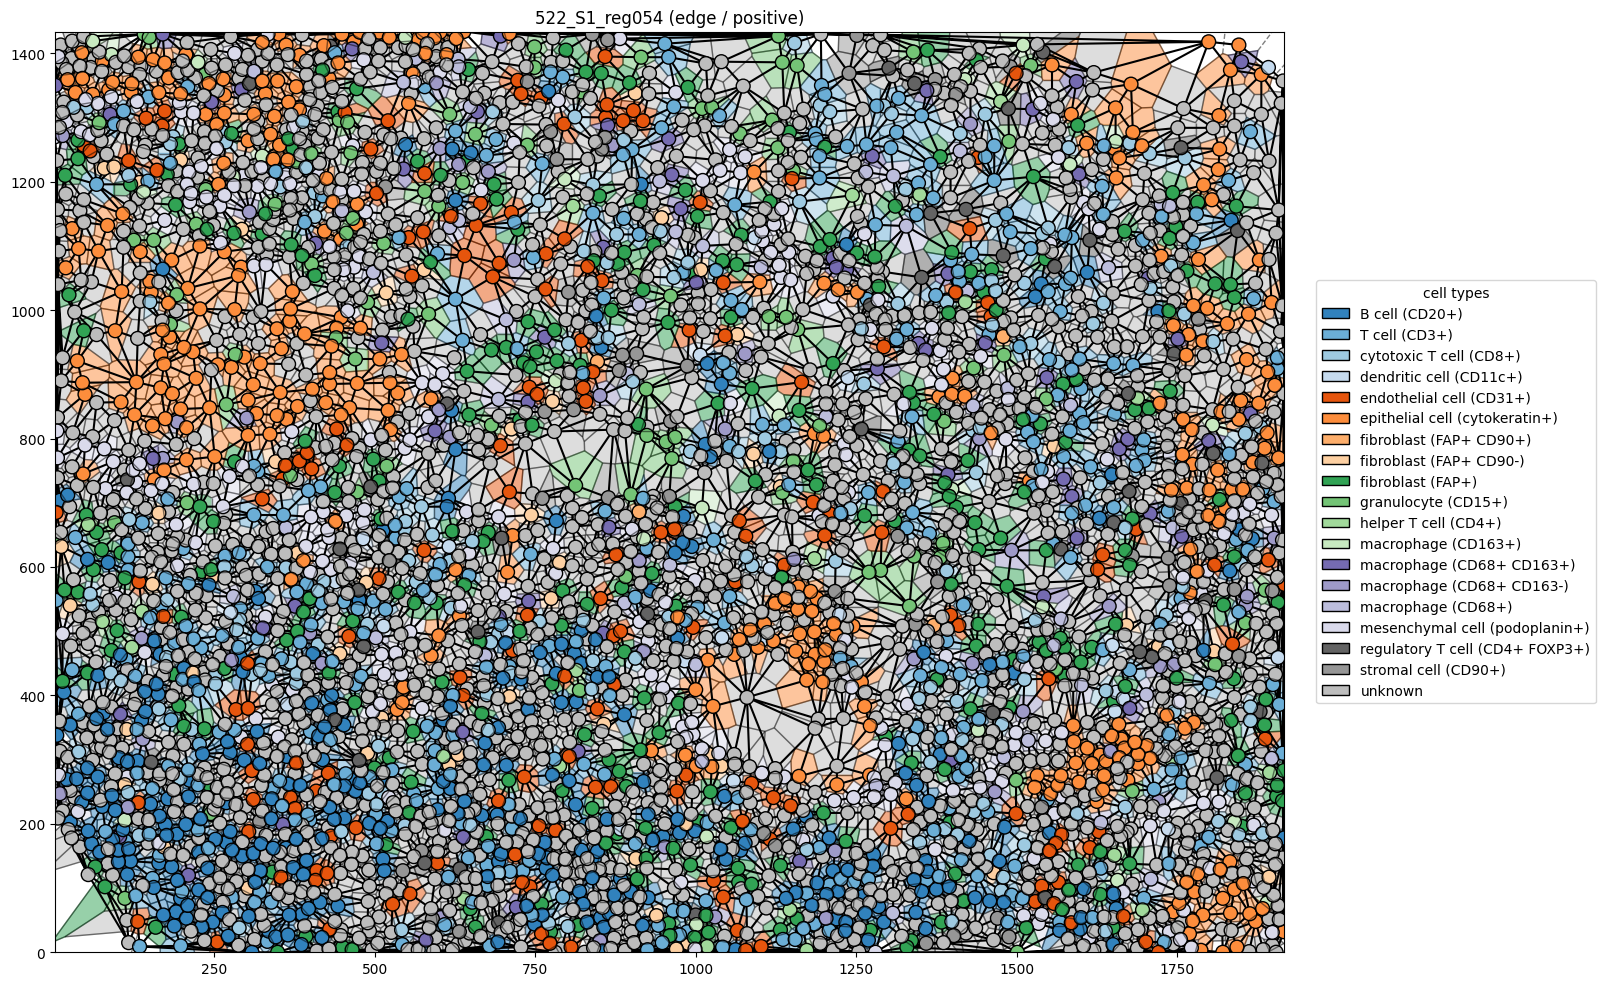

In [5]:
random.seed(42)

edge_sample_name, edge_sample = random.choice(list(edge_representations.items()))

fig, ax = plt.subplots(figsize = (15, 10))

graph_utilities.plot_voronoi_diagram(edge_sample["voronoi"], edge_sample["assignments"], ax)
graph_utilities.plot_delaunay_triangulation(edge_sample["delaunay"], edge_sample["assignments"], ax)

ax.set_title(f'{edge_sample_name} ({edge_sample["regionalization"]} / {edge_sample["nodal_status"]})')

plt.tight_layout()

In [6]:
random.seed(42)

sampled_edge_representations = dict(random.sample(list(edge_representations.items()), 5))
sampled_center_representations = dict(random.sample(list(center_representations.items()), 5))

In [7]:
edge_microenvironments = graph_utilities.construct_microenvironments(sampled_edge_representations)
center_microenvironments = graph_utilities.construct_microenvironments(sampled_center_representations)

here, we visualize a microenvironment from an edge sample, defined as the 3 hop neighborhood of any cell

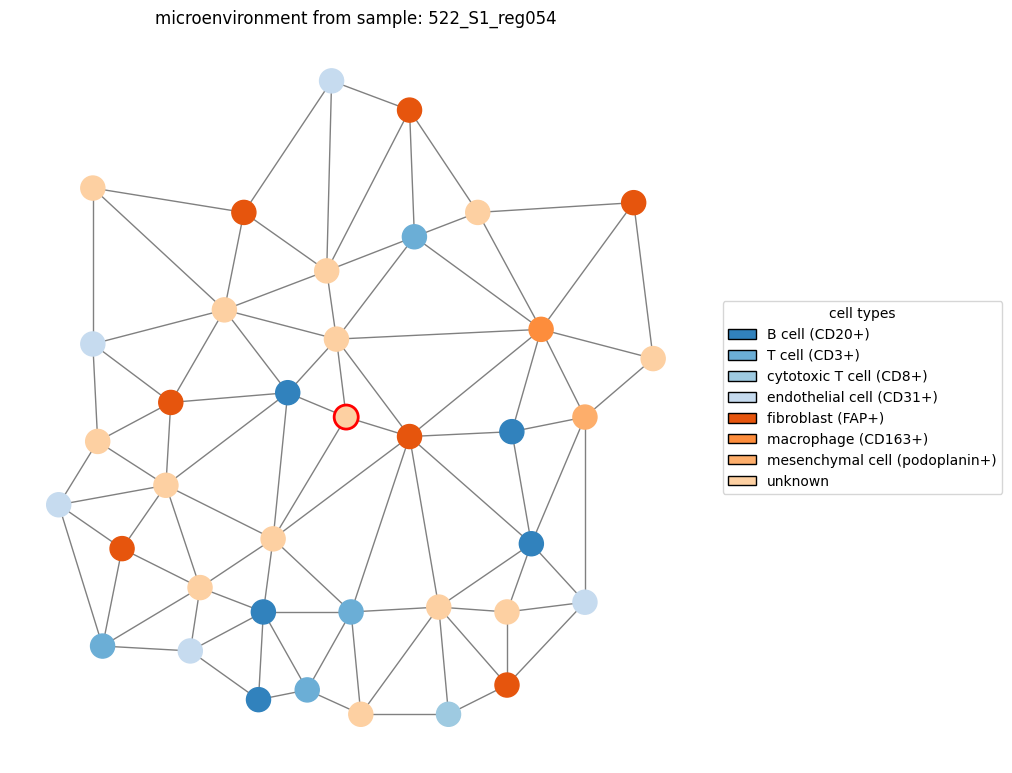

In [8]:
random.seed(42)

edge_sample_name, edge_sample_microenvironments = random.choice(list(edge_microenvironments.items()))
edge_center_node = random.choice(range(len(edge_sample_microenvironments)))

fig, ax = plt.subplots(figsize = (10, 10))

graph_utilities.plot_microenvironment(edge_sample_microenvironments[edge_center_node], edge_center_node, ax)

ax.set_title(f"microenvironment from sample: {edge_sample_name}")
plt.tight_layout()

# MODELS

In [9]:
from source import data
from source import models
from source import training_and_evaluation

In [10]:
mapping = assignments[["FINAL_CELL_TYPE", "CELL_TYPE_NUMBER"]].drop_duplicates()
mapping = dict(zip(mapping["FINAL_CELL_TYPE"], mapping["CELL_TYPE_NUMBER"].astype(int)))

edge_microenvironments = data.prepare_data(edge_microenvironments, mapping, 1)
center_microenvironments = data.prepare_data(center_microenvironments, mapping, 0)

all_microenvironments = edge_microenvironments + center_microenvironments

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = len(np.unique(assignments["FINAL_CELL_TYPE"]))
output_dim = len(torch.unique(torch.cat([data.y for data in all_microenvironments])))
hidden_dim = 64

model_type = "GIN"
model = models.TumorGINClassifier(input_dim, hidden_dim, output_dim).to(device)

optimizer = Adam(model.parameters(), lr = 0.001)

features = [microenvironment.x for microenvironment in all_microenvironments]
labels = [microenvironment.y.item() for microenvironment in all_microenvironments]

splitter = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in splitter.split(features, labels):
    train_data = [all_microenvironments[i] for i in train_index]
    test_data = [all_microenvironments[i] for i in test_index]

train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 32, shuffle = False)

In [12]:
epochs = 5

train_losses_list = []
train_metrics_list = []
test_metrics_list = []

os.makedirs("results", exist_ok = True)

for epoch in range(1, epochs + 1):
    train_loss, train_metrics = training_and_evaluation.train_epoch(model, train_loader, optimizer, 
                                                                        cross_entropy, device)
    test_metrics = training_and_evaluation.evaluate_epoch(model, test_loader, device)
    
    train_losses_list.append(train_loss)
    train_metrics_list.append(train_metrics)
    test_metrics_list.append(test_metrics)

    print(f'epoch {epoch}, loss: {train_loss:.4f}, test accuracy: {test_metrics["accuracy"]:.4f}')    

torch.save(model.state_dict(), f"results/{model_type}.pth")

with open(f"results/{model_type}_training_losses.txt", "w") as loss_file:
    for epoch, loss in enumerate(train_losses_list, 1):
        epoch_summary = {"epoch": epoch, "train_loss": loss}
        loss_file.write(f"{epoch_summary}\n")

with open(f"results/{model_type}_training_metrics.txt", "w") as train_file:
    for epoch, metrics in enumerate(train_metrics_list, 1):
        epoch_summary = {"epoch": epoch, **metrics}
        train_file.write(f"{epoch_summary}\n")

with open(f"results/{model_type}_evaluation_metrics.txt", "w") as evaluation_file:
    for epoch, metrics in enumerate(test_metrics_list, 1):
        epoch_summary = {"epoch": epoch, **metrics}
        evaluation_file.write(f"{epoch_summary}\n")

epoch 1, loss: 0.3599, test accuracy: 0.8562
epoch 2, loss: 0.2576, test accuracy: 0.9123
epoch 3, loss: 0.1869, test accuracy: 0.9381
epoch 4, loss: 0.1429, test accuracy: 0.9582
epoch 5, loss: 0.1131, test accuracy: 0.9595


# INTERPRETABILITY

In [13]:
from source import interpretability

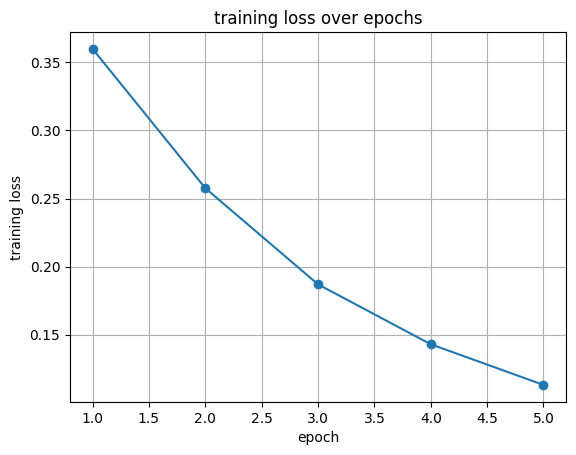

In [14]:
interpretability.plot_training_losses(f"results/{model_type}_training_losses.txt")

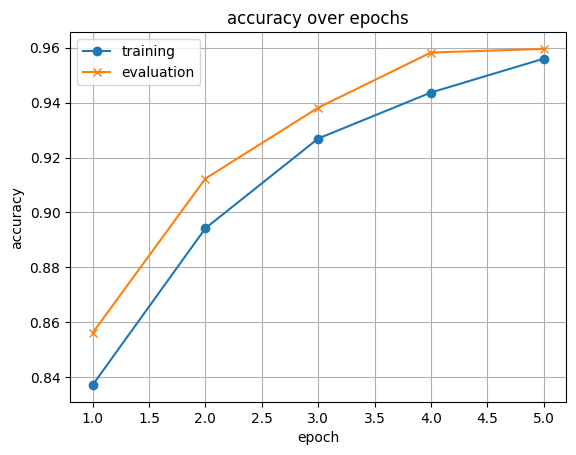

In [15]:
interpretability.plot_performance_measures(f"results/{model_type}_training_metrics.txt",
                                           f"results/{model_type}_evaluation_metrics.txt",
                                           metric = "accuracy")

In [16]:
model = models.TumorGINClassifier(input_dim, hidden_dim, output_dim).to(device)
model.load_state_dict(torch.load(f"results/{model_type}.pth"))

embeddings, probability_predictions, labels = interpretability.extract_embeddings(model, train_loader, device)

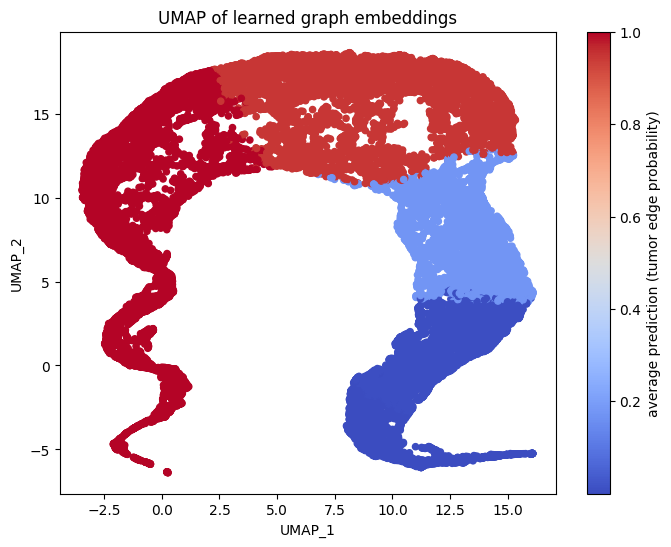

In [17]:
interpretability.visualize_embeddings(embeddings, probability_predictions, 8)